## 4차 과제 - Hyperparameter Tuning을 해보자
- 주제: 하이퍼파라미터 튜닝 기법 학습
- 데이터: The History of Baseball(Pitching Data) https://www.kaggle.com/datasets/seanlahman/the-history-of-baseball?select=pitching.csv
- 사용 라이브러리: pandas, numpy, matplotlib, sklearn, imblearn, bayes_opt

### 1. EDA, 전처리

1.1 분석을 위해 사용될 라이브러리들을 import 하세요.

numpy, pandas, matplotlib, SMOTE, train_test_split, RandomForestClassifier, RandomizedSearchCV, GridSearchCV, BayesianOptimization, accuracy_score

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score

In [13]:
#pip install bayesian-optimization

1.2 데이터를 불러오고 info()를 통해 데이터를 살펴보세요.

In [14]:
data = pd.read_csv('pitching.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44139 entries, 0 to 44138
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player_id  44139 non-null  object 
 1   year       44139 non-null  int64  
 2   stint      44139 non-null  int64  
 3   team_id    44139 non-null  object 
 4   league_id  44008 non-null  object 
 5   w          44139 non-null  int64  
 6   l          44139 non-null  int64  
 7   g          44139 non-null  int64  
 8   gs         44139 non-null  int64  
 9   cg         44139 non-null  int64  
 10  sho        44139 non-null  int64  
 11  sv         44139 non-null  int64  
 12  ipouts     44138 non-null  float64
 13  h          44139 non-null  int64  
 14  er         44139 non-null  int64  
 15  hr         44139 non-null  int64  
 16  bb         44139 non-null  int64  
 17  so         44139 non-null  int64  
 18  baopp      42614 non-null  float64
 19  era        44049 non-null  float64
 20  ibb   

1.3 null 값이 있는 컬럼은 모두 삭제하겠습니다(원래는 다른 처리를 해야 하지만 컬럼 수는 충분하니까..ㅎㅎ 야구 잘 몰라서 그런 거 아닙니다.).

In [15]:
data.dropna(axis = 1, inplace=True)

1.4 연도 별로 몇개의 데이터가 있는 지 확인 후 데이터가 얼마 없는 과거 데이터는 삭제하겠습니다. 이를 위해 연도 별 데이터 수를 계산하고 line plot으로 그리세요.

year
1871     19
1872     23
1873     25
1874     17
1875     47
       ... 
2011    707
2012    722
2013    726
2014    746
2015    809
Length: 145, dtype: int64


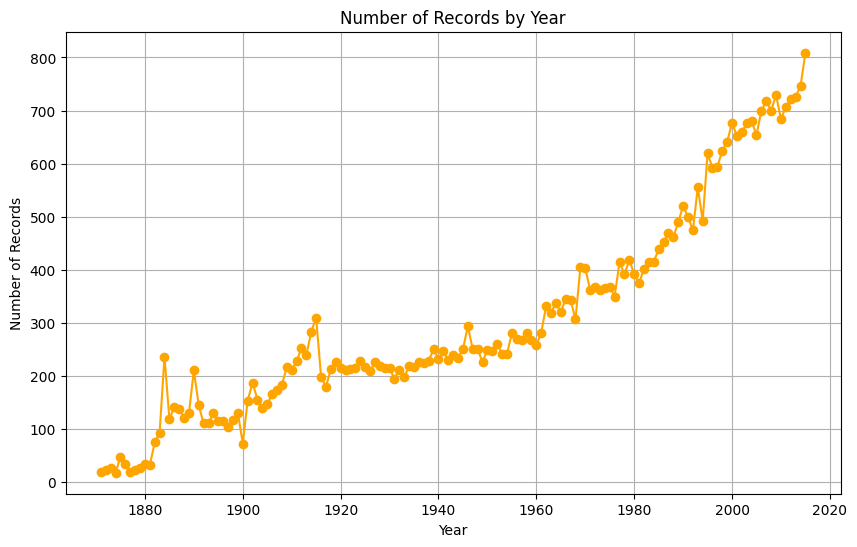

In [16]:
year_data=data.groupby('year').size()
print(year_data)

plt.figure(figsize=(10, 6))
plt.plot(year_data.index, year_data.values, marker='o', linestyle='-', color='orange')
plt.title('Number of Records by Year')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.grid(True)
plt.show()

1.5 보다 최신 분석을 위해 1980년 이후의 데이터만 남기고 몇개의 데이터가 남았는지 확인하세요.

In [17]:
data = data[data['year'] >= 1980]

In [18]:
data['year'].value_counts()

year
2015    809
2014    746
2009    729
2013    726
2012    722
2007    718
2011    707
2006    700
2008    700
2010    684
2004    680
2000    677
2003    676
2002    659
2005    654
2001    652
1999    641
1998    624
1995    619
1997    594
1996    592
1993    555
1990    520
1991    499
1994    492
1989    489
1992    474
1987    469
1988    461
1986    453
1985    438
1984    415
1983    415
1982    402
1980    392
1981    374
Name: count, dtype: int64

In [19]:
print("총 데이터 수", len(data))

총 데이터 수 21157


1.6 reset_index()를 통해 재배열하세요.

In [20]:
data = data.reset_index(drop= True)   #설정인덱스제거,열추가X

1.7 투수의 승리 수를 예측해보겠습니다. w 컬럼의 value를 확인해보세요.

In [21]:
data['w'].value_counts()

w
0     5854
1     3197
2     2356
3     1744
4     1453
5     1114
6      878
7      730
9      560
8      557
10     450
11     434
12     384
13     317
14     287
15     242
16     193
17     125
18     102
19      61
20      53
21      32
22      17
24       8
23       7
25       1
27       1
Name: count, dtype: int64

1.8 0승 투수(출전하지 않은 경우도 존재)가 많으므로 승리 수가 0인 데이터는 삭제하겠습니다.

In [22]:
data = data[data['w'] != 0]
len(data)

15303

1.9 Regression이 아닌 Classification으로 분석해보겠습니다. 이를 위해 10을 기준으로 w를 10승 이상이면 1, 10승 미만이면 0인 Binary 형태로 변환하세요.

In [23]:
data['w'] = [1 if value >= 10 else 0 for value in data['w']]
data

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,0,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,1,11,35,35,7,1,0,227,108,20,74,114,0,120
4,allenne01,1980,1,NYN,0,10,59,0,0,0,22,87,40,7,40,79,1,43
6,andujjo01,1980,1,HOU,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,wrighmi01,2015,1,BAL,0,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,wrighst01,2015,1,BOS,0,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,yateski01,2015,1,TBA,0,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,youngch03,2015,1,KCA,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.10 value_counts()를 통해 잘 나눠졌는지 확인해보세요.

In [24]:
data['w'].value_counts()

w
0    12589
1     2714
Name: count, dtype: int64

1.11 종속 변수의 밸런스가 맞지 않는 것으로 확인됩니다. 이를 해결하기 위해 Under Sampling 혹은 Over Sampling 기법을 사용할 수 있는데 Under Sampling의 경우 데이터가 많지 않는 상황에서 사라지는 데이터가 과도하게 많으므로 Over Sampling 기법 중 SMOTE 기법을 사용해보겠습니다. 사용하기 전에 player_id, year, team_id 컬럼은 지우고 가겠습니다.

In [25]:
data = data.drop(columns = ['player_id', 'year', 'team_id'])
data

,stint,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,1,0,13,40,21,5,1,2,193,79,13,66,74,1,83
1,1,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,1,1,11,35,35,7,1,0,227,108,20,74,114,0,120
4,1,0,10,59,0,0,0,22,87,40,7,40,79,1,43
6,1,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,1,0,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,1,0,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,1,0,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,1,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.12 SMOTE 기법을 활용해 w의 balance를 맞추세요(sampling_strategy='auto', random_state = 123).

In [26]:
smote = SMOTE(sampling_strategy='auto', random_state=123)
X, y = smote.fit_resample(data.drop(columns=['w']) , data['w'])

1.13 balance가 잘 맞춰졌는지 확인하세요.

In [27]:
print("전",data['w'].value_counts())
print("후",y.value_counts())

전 w
0    12589
1     2714
Name: count, dtype: int64
후 w
0    12589
1    12589
Name: count, dtype: int64


1.14 SMOTE의 동작 방식에 대해 작성하고 Over Sampling의 장/단점에 대해 작성하세요.

SMOTE는 부트스트래핑이나 KNN(최근접이웃) 모델 기법을 이용하여, 다수 클래스를 샘플링하고 기존 소수 샘플을 보간하여 클래스의 불균형을 해결한다.
데이터를 증가시키기 때문에 정보 손실이 없으나, 과적합 가능성과 노이즈나 이상치에 민감하다는 단점이 있다.

1.15 다른 Over Sampling 기법들엔 어떤 것들이 있는지 작성하세요(2개 이상).


**1. ADASYN**

ADASYN 방법은 Borderline SMOTE 방법과 비슷하지만 샘플링 개수를 데이터 위치에 따라 다르게 설정하는 것이 차이점이다.


**2. GAN**

GAN (Generative Adversarial Nets) 는 생성자와 구분자로 구성되어 있고 모델은 딥러닝을 사용하는 최신 오버 샘플링 기법이다.

### 2. 예측 및 분석

2.1 본격적으로 분석을 진행하겠습니다. 본 차시는 Hyperparameter Tuning에 대해 학습하는 것이 목적이므로 모델은 RandomForest Classifier 하나만 사용하도록 하겠습니다. 먼저 데이터를 train, validation, test 3개로 나누세요(trian-60%, val-20%, test-20%).

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123, stratify=y_train)

print('Train set size: ', len(X_train))
print('Validation set size: ', len(X_val))
print('Test set size: ', len(X_test))

Train set size:  16113
Validation set size:  4029
Test set size:  5036


2.2 train test에 validation set을 추가하는 이유가 뭔지 작성하세요.

**train set을 validation set으로 분리함으로써, 과적합을 방지하고 학습의 성능 평가하기 위함이다.**

2.3 Randomized SearchCV로 최적의 파라미터 셋을 찾으세요(성능 지표는 accuracy score).

In [29]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}



randomforest = RandomForestClassifier()
randomsearch = RandomizedSearchCV(estimator = randomforest, param_distributions = param_grid, scoring = 'accuracy', random_state = 123)
randomsearch.fit(X_train, y_train)

print('최적의 파라미터: ', randomsearch.best_params_, 'accuracy score: ',randomsearch.best_score_)

최적의 파라미터:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True} accuracy score:  0.9532059782140816


2.4 위에서 지정한 hyperparameter들이 각각 무엇을 의미하는지 작성하세요.

* n_estimators: 랜덤 포레스트에서 사용할 결정 트리 개수 지정

* min_samples_split: 노드 분할을 위한 최소 데이터 수 지정

* min_samples_leaf: 말단 노드가 되기 위한 최소 데이터 개수 지정

* max_depth: 트리의 최대 깊이 지정

* criterion: 노드 분할 기준 지정. 'gini'는 지니 불순도를 사용, 'entropy'는 정보 이득을 사용

* booststrap: 부트스트랩 샘플링은 데이터에서 중복을 허용하고 무작위로 샘플을 추출하는 방법으로, 이 데이터 샘플링을 사용하여 트리를 학습할지를 결정

2.5 Grid SearchCV로 최적의 파라미터 셋을 찾으세요.

In [30]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [31]:
randomforest = RandomForestClassifier()
gridsearch = GridSearchCV(estimator = randomforest, param_grid = param_grid, scoring = 'accuracy', cv = 5)
gridsearch.fit(X_train, y_train)

print('최적의 파라미터: ', gridsearch.best_params_, 'accuracy score: ',gridsearch.best_score_)

최적의 파라미터:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} accuracy score:  0.9596602284210727


2.6 Randomized SearchCV와 Grid SearchCV의 차이와 장단점에 대해 설명하세요.

<figure>
    <img src="https://miro.medium.com/v2/resize:fit:781/1*8uSZqUSGa-UGF-0CDBd4Jw.png">
</figure>

*  **Grid SearchCV:**

 Grid SearchCV는 주어진 하이퍼파라미터 그리드에서 모든 조합을 시도해 최적의 조합을 찾는다. 완전한 탐색으로 최적의 조합을 찾을 수 있으나 비용과 시간이 많이 소모된다.

* **Randomized SearchCV:**

 Randomized SearchCV는 주어진 하이퍼파라미터 분포에서 무작위로 조합을 선택하여 탐색한다. 계산이 적고 비교적 효율적으로 탐색이 가능하나 주어진 공간내에서만 무작위로 탐색하기 때문에 최적의조합을 찾을 확률이 위보다 낮다.

2.7 이번엔 Bayesian Optimization을 사용해 파라미터 튜닝을 진행해보겠습니다.

In [32]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [36]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.2 MB/s eta 0:00:00


In [45]:
from skopt import BayesSearchCV

randomforest = RandomForestClassifier()
bayessearch = BayesSearchCV(estimator=randomforest, search_spaces=param_grid, scoring='accuracy')
bayessearch.fit(X_train, y_train)

print('최적의 파라미터: ', bayessearch.best_params_, 'accuracy score: ',bayessearch.best_score_)

최적의 파라미터:  OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 30), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)]) accuracy score:  0.9599705176153781


2.8 진행한 튜닝 과정에서 찾은 최적의 파라미터 셋으로 다시 학습을 진행한 후 최종 accuracy score을 출력하세요.

In [50]:
best_params = bayessearch.best_params_
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train, y_train)

y_val_pred = best_rf_model.predict(X_val)
print("accuracy score:", accuracy_score(y_val, y_val_pred))

accuracy score: 0.9589654314847053


### 3. 자유분석

최적의 파라미터 셋을 찾고 성능을 높여보세요.

**'ADASYN'이라는 OverSampling 기법을 사용해서 위와 동일하게 Randomized SearchCV와 Grid SearchCV를 통해 최적의 하이퍼파라미터를 찾고 최종 정확도를 출력해보자.**

In [47]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=123)
X, y = adasyn.fit_resample(data.drop(columns=['w']) , data['w'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123, stratify=y_train)


param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

randomforest = RandomForestClassifier()
randomsearch = RandomizedSearchCV(estimator = randomforest, param_distributions = param_grid, scoring = 'accuracy', random_state = 123)
randomsearch.fit(X_train, y_train)
print('최적의 파라미터: ', randomsearch.best_params_, 'accuracy score: ',randomsearch.best_score_)

randomforest = RandomForestClassifier(randomsearch.best_params_)
randomsearch.fit(X_train, y_train)

y_val_grid = randomsearch.predict(X_val)
accuracy = accuracy_score(y_val, y_val_grid)
print('accuracy score: ', accuracy)

최적의 파라미터:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True} accuracy score:  0.9503200696857645
accuracy score:  0.95026112907237


In [48]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

randomforest = RandomForestClassifier()
gridsearch = GridSearchCV(estimator = randomforest, param_grid = param_grid, scoring = 'accuracy', cv = 5)
gridsearch.fit(X_train, y_train)
print('최적의 파라미터: ', gridsearch.best_params_, 'accuracy score: ',gridsearch.best_score_)


randomforest = RandomForestClassifier(**gridsearch.best_params_)
gridsearch.fit(X_train, y_train)

y_val_grid = randomsearch.predict(X_val)
accuracy = accuracy_score(y_val, y_val_grid)
print('accuracy score: ', accuracy)

최적의 파라미터:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} accuracy score:  0.9572218562147299
accuracy score:  0.95026112907237
